In [1]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [2]:
drive_dataset_path = "/content/drive/MyDrive/MaskDetectionDataset/facemask_dataset/"

In [156]:
# -*- coding: utf-8 -*-
"""
Created on Mon May  2 21:10:19 2022

@author: harsh
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as opt
import tqdm

# Global variables
input_shape = 124
batch_size = 64
input_channels = 3
learning_rate = 0.008
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 20
num_classes = 2

class FaceMaskClassifier2(nn.Module):
    def __init__(self):
        super(FaceMaskClassifier2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=256, kernel_size=5, stride=1, padding=2)
        self.batch_norm1 = nn.BatchNorm2d(num_features=256)
        self.drop = nn.Dropout2d(p=0.2)

        self.conv2 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(num_features=128)

        self.conv3 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.batch_norm3 = nn.BatchNorm2d(num_features=64)


        self.lastcnn = nn.Conv2d(in_channels=64, out_channels=2, kernel_size=31, stride=1, padding=0)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = self.batch_norm1(x)
        x = self.drop(x)

        x = self.maxpool(x)

        x = F.relu(self.conv2(x))
        x = self.batch_norm2(x)
        x = self.drop(x)


        x = F.relu(self.conv3(x))
        x = self.batch_norm3(x)
        x = self.drop(x)
    
        x = self.maxpool(x)
        x = self.lastcnn(x)

        return x

# load the dataset
def load_dataset():
    # defining data transformations
    my_transform = transforms.Compose([
         transforms.Resize((input_shape, input_shape)),
         transforms.ColorJitter(brightness=0.4),
         transforms.RandomRotation(degrees=45),
         transforms.RandomHorizontalFlip(p=0.5),
         transforms.RandomVerticalFlip(p=0.5),
         transforms.RandomGrayscale(p=0.2),
         transforms.ToTensor(),
         transforms.Normalize(mean=0.0, std=1.0)
    ])

    # loading the data
    dataset = datasets.ImageFolder(drive_dataset_path,transform=my_transform)

    # splitting the data into train test and validation
    data_len = len(dataset)
    print("Length of the data is : "+str(data_len))
    train_set_size = int(data_len * 0.8)
    valid_set_size = int(train_set_size * 0.1)+1
    train_set_size2 = int(train_set_size * 0.9)
    test_set_size = int((data_len - train_set_size))
    print(f" Training data size: {train_set_size2}\n Validation data size: {valid_set_size} \n Testing data size: {test_set_size}\n")
    train_data, test_data = data.random_split(dataset, [train_set_size, test_set_size])
    train_data, valid_data = data.random_split(train_data, [train_set_size2, valid_set_size])

    # defining the data loaders
    train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=8)
    valid_loader = DataLoader(valid_data, batch_size=batch_size, num_workers=4)
    test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=4)

    img, l = next(iter(train_loader))
    return train_loader, valid_loader, test_loader


# Train model

def train2(train_loader, valid_loader, model, criterion, optimizer):
    print("Begin training.")
    for ep in range(num_epochs):
        # TRAINING
        train_epoch_loss = 0
        train_epoch_acc = 0
        model.train()
        for X_train_batch, y_train_batch in train_loader:
            X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
            optimizer.zero_grad()
            y_train_pred = model(X_train_batch).squeeze()
            train_loss = criterion(y_train_pred, y_train_batch)
            train_acc = binary_acc(y_train_pred, y_train_batch)
            train_loss.backward()
            optimizer.step()
            train_epoch_loss += train_loss.item()
            train_epoch_acc += train_acc.item()
        # VALIDATION
        with torch.no_grad():
            model.eval()
            val_epoch_loss = 0
            val_epoch_acc = 0
            for X_val_batch, y_val_batch in valid_loader:
                X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
                y_val_pred = model(X_val_batch).squeeze()
                #y_val_pred = torch.unsqueeze(y_val_pred, 0)
                val_loss = criterion(y_val_pred, y_val_batch)
                val_acc = binary_acc(y_val_pred, y_val_batch)
                val_epoch_loss += val_loss.item()
                val_epoch_acc += val_acc.item()
        loss_stats['train'].append(train_epoch_loss / len(train_loader))
        loss_stats['val'].append(val_epoch_loss / len(valid_loader))
        accuracy_stats['train'].append(train_epoch_acc / len(train_loader))
        accuracy_stats['val'].append(val_epoch_acc / len(valid_loader))
        print(
            f'Epoch {ep + 0:02}: | Train Loss: {train_epoch_loss / len(train_loader):.5f} | Val Loss: {val_epoch_loss / len(valid_loader):.5f} | Train Acc: {train_epoch_acc / len(train_loader):.3f}| Val Acc: {val_epoch_acc / len(valid_loader):.3f}')

def binary_acc(y_pred, y_test):
    y_pred_tag = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_tag, dim = 1)
    correct_results_sum = (y_pred_tags == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

def evaluate(loader, model, model_type="nn"):
    correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            if (model_type == "nn"):
                x = x.reshape(x.shape[0], -1)

            score = model(x)

            y_pred_tag = torch.log_softmax(score, dim=1)
            _, y_pred_tags = torch.max(y_pred_tag, dim=1)
            #_, preds = score.max(1)
            correct += (y_pred_tags == y).sum()
            num_samples += y_pred_tag.shape[0]

    num_samples = 1 if num_samples == 0 else num_samples
    accuracy = 100 * (correct / num_samples)
    return accuracy


def main():
    train_loader, valid_loader, test_loader = load_dataset()

    # Initializing the model

    model = FaceMaskClassifier2().to(device)

    optimizer = opt.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    print(torch.cuda.is_available())
    print("Model detials: \n")
    print(model)

    print("\n Training The Model")
    train2(train_loader, valid_loader, model, criterion, optimizer)

    return model






In [157]:
model = main()

Length of the data is : 20043
 Training data size: 14430
 Validation data size: 1604 
 Testing data size: 4009

True
Model detials: 

FaceMaskClassifier2(
  (conv1): Conv2d(3, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batch_norm1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout2d(p=0.2, inplace=False)
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lastcnn): Conv2d(64, 2, kernel_size=(31, 31), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

 Training The Model
Begin training.
Epoch 00: | Train Loss: 9.89721 | Val Loss: 8.65768 | Train Acc: 80.283| Val Acc: 82.

Save the Trained Model

In [158]:
model_path = "/content/drive/MyDrive/MaskDetectionDataset/models/cnn_scratch.pt"
torch.save(model.state_dict(), model_path)

In [54]:
model1 = FaceMaskClassifier2()
model1.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [57]:
def get_model():
  """
  loads the saved model 
  """
  model_path = "/content/drive/MyDrive/MaskDetectionDataset/models/cnn_scratch.pt"
  model1 = FaceMaskClassifier2()
  model1.load_state_dict(torch.load(model_path))
  return model1



In [160]:
from torch.nn.utils import prune
import seaborn as sns
class prune_model():
  def __init__(self, loader, model_path, prune_type='l1_unstructured'):
    self.loader = loader
    self.prune_type = prune_type
    

  def get_model(self, model_path = "/content/drive/MyDrive/MaskDetectionDataset/models/cnn_scratch.pt"):
    """
    loads the saved model 
    """
    #model_path = "/content/drive/MyDrive/MaskDetectionDataset/models/cnn_scratch.pt"
    model1 = FaceMaskClassifier2()
    model1.load_state_dict(torch.load(model_path))
    self.model = model1
    return model1

  def get_model_modules(self, mdl):
    layers = []

    def unwrap_recur(modules):
      for md in modules.children():
        if isinstance(md, nn.Sequential):
          unwrap_recur(md)
        elif isinstance(md, nn.ModuleList):
          for m in md:
            unwrap_recur(m)
        else:
          layers.append(md)

    unwrap_recur(mdl)

    return nn.ModuleList(layers)

  def prune_model_l1_unstructured(self, model, ly_type, ratio):
    """
    Model pruning
    """
    modules = get_model_modules(model)
    for m in modules.children():
      if isinstance(m, ly_type):
        prune.l1_unstructured(m, 'weight', ratio)
        prune.remove(m, 'weight')
    return model

  def prune_model_l1_structured(self, model, ly_type, ratio):
    """
    Model pruning
    """
    modules = get_model_modules(model)
    for m in modules.children():
      if isinstance(m, ly_type):
        prune.ln_structured(m, 'weight', ratio, n=1, dim=1)
        prune.remove(m, 'weight')
    return model

  def get_eval(self, model, loader):
    criterion = nn.CrossEntropyLoss()
    model.eval().to(device)
    val_loss = []
    val_epoch_loss = 0.0
    val_epoch_acc = 0.0
    with torch.no_grad():
      for X_val_batch, y_val_batch in loader:
        X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
        #y_val_pred = model(X_val_batch).squeeze()
        y_val_pred = model(X_val_batch).squeeze()
        val_loss = criterion(y_val_pred, y_val_batch)
        val_acc = binary_acc(y_val_pred, y_val_batch)
        val_epoch_loss += val_loss.item()
        val_epoch_acc += val_acc.item()

    print("Accuracy: "+str(val_epoch_acc / len(loader))+" Loss : " + str(val_epoch_loss / len(loader)))
    return val_epoch_acc / len(loader), val_epoch_loss / len(loader)

  def prune(self, model_, prune_fn, eval_fn):
    losses = []
    accuracy = []

    print("Evaluating the model with 0 pruning")
    model = model_()
    acc, loss = eval_fn(model, self.loader)
    losses.append((0, loss))
    accuracy.append((0, acc))

    # Pruning 
    for i in range(1, 18):
      ratio = i*0.05
      print(f"Evaluating model with {ratio} pruning")
      model = model_()
      pruned_model = prune_fn(model, nn.Conv2d, ratio)
      acc, loss = eval_fn(pruned_model, self.loader)
      losses.append((ratio, loss))
      accuracy.append((ratio, acc))
    
    return accuracy, losses
  
  def plot(self, acc, losses, title):
    (pd.DataFrame(losses, columns=['sparsity', 'loss'])
    .pipe(lambda df: df.assign(
        perf=(df.loss - pd.Series([losses[0][1]] * len(df))) / losses[0][1] + 1
    ))
    .head(10)
    .plot.line(x='sparsity', y='perf', figsize=(12, 8), title=title)
    )
    sns.despine()

  def fit(self):
    if self.prune_type == "l1_unstructured":
      accs, losses = self.prune(self.get_model, self.prune_model_l1_unstructured, self.get_eval)
      #self.plot(accs, loss, "L1_Ustructured")
    else:
      accs, losses = self.prune(self.get_model, self.prune_model_l1_structured, self.get_eval)
      #self.plot(accs, loss, "L1_structured")
    return accs, losses


In [159]:
model_path = "/content/drive/MyDrive/MaskDetectionDataset/models/cnn_scratch.pt"

Unstructured Pruing

In [161]:
train_loader, valid_loader, test_loader = load_dataset()
p = prune_model(test_loader, model_path)
accuracy_unstructured, loss_unstructured = p.fit()


Length of the data is : 20043
 Training data size: 14430
 Validation data size: 1604 
 Testing data size: 4009

Evaluating the model with 0 pruning
Accuracy: 96.0 Loss : 0.1056804559119637
Evaluating model with 0.05 pruning
Accuracy: 96.2063492063492 Loss : 0.10618090594098681
Evaluating model with 0.1 pruning
Accuracy: 96.17460317460318 Loss : 0.10285414320727189
Evaluating model with 0.15000000000000002 pruning
Accuracy: 96.53968253968254 Loss : 0.10832761529655684
Evaluating model with 0.2 pruning
Accuracy: 96.42857142857143 Loss : 0.10299941637213268
Evaluating model with 0.25 pruning
Accuracy: 96.46031746031746 Loss : 0.10802976065684879
Evaluating model with 0.30000000000000004 pruning
Accuracy: 96.12698412698413 Loss : 0.1058433647193606
Evaluating model with 0.35000000000000003 pruning
Accuracy: 95.60317460317461 Loss : 0.12252467102001584
Evaluating model with 0.4 pruning
Accuracy: 94.57142857142857 Loss : 0.13663132441422296
Evaluating model with 0.45 pruning
Accuracy: 93.666

Structured Pruning

In [162]:
train_loader, valid_loader, test_loader = load_dataset()
p = prune_model(test_loader, model_path, "l1_structured")
accuracy_structured, loss_structured = p.fit()

Length of the data is : 20043
 Training data size: 14430
 Validation data size: 1604 
 Testing data size: 4009

Evaluating the model with 0 pruning
Accuracy: 96.0952380952381 Loss : 0.10535446761382951
Evaluating model with 0.05 pruning
Accuracy: 95.9047619047619 Loss : 0.11264772550572479
Evaluating model with 0.1 pruning
Accuracy: 96.42857142857143 Loss : 0.10423706158522576
Evaluating model with 0.15000000000000002 pruning
Accuracy: 96.12698412698413 Loss : 0.10526635784596677
Evaluating model with 0.2 pruning
Accuracy: 48.96825396825397 Loss : 2.2405332705331227
Evaluating model with 0.25 pruning
Accuracy: 48.93650793650794 Loss : 2.1813234753078885
Evaluating model with 0.30000000000000004 pruning
Accuracy: 48.96825396825397 Loss : 2.1805886370795116
Evaluating model with 0.35000000000000003 pruning
Accuracy: 48.95238095238095 Loss : 1.8986615377759177
Evaluating model with 0.4 pruning
Accuracy: 48.95238095238095 Loss : 1.7303323897104415
Evaluating model with 0.45 pruning
Accurac

Plotting results Loss

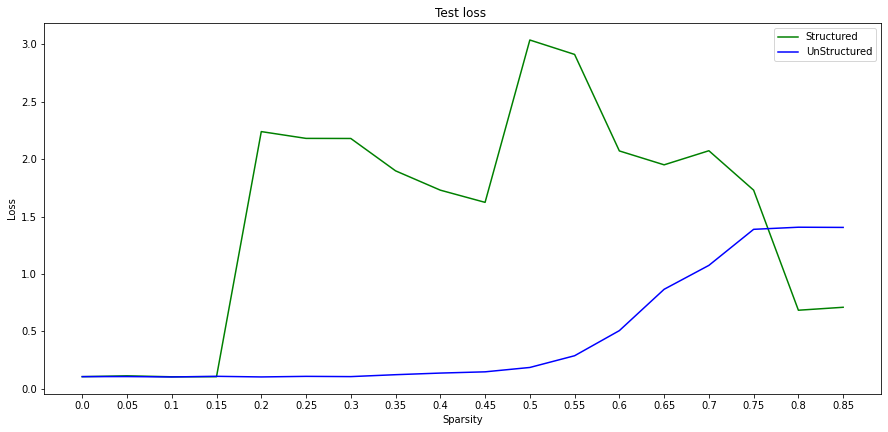

In [171]:
ratio = []
losses_un = []
losses_st = []
for i in loss_unstructured:
  r, ls = i[0], i[1]
  ratio.append(float("{:.2f}".format(r)))
  losses_un.append(ls)

for i in loss_structured:
  r, ls = i[0], i[1]
  losses_st.append(ls)

fig1 =  plt.figure(figsize=(15, 15))
plt.clf()
plt.ylim(0,5)
plt.subplot(211)
plt.title("Test loss ")
plt.plot(losses_st, 'g-')
plt.plot(losses_un, 'b-')
default_x_ticks = range(len(ratio))
#plt.plot(default_x_ticks, y)
plt.xticks(default_x_ticks, ratio)

plt.ylabel('Loss')
plt.xlabel('Sparsity')
plt.legend(['Structured','UnStructured'], loc='upper right')
plt.show() 

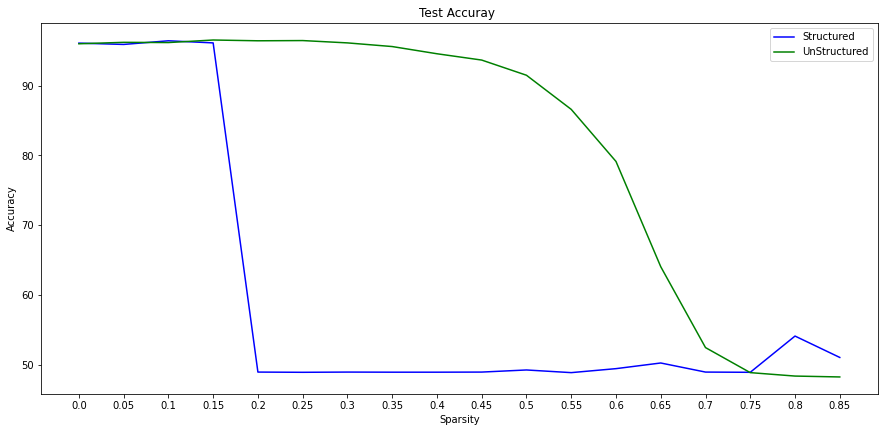

In [172]:
ratio = []
acc_uns = []
acc_str = []

for i in accuracy_unstructured:
  r, ac = i[0], i[1]
  ratio.append(float("{:.2f}".format(r)))
  acc_uns.append(ac)

for i in accuracy_structured:
  r, ac = i[0], i[1]
  acc_str.append(ac)

fig1 =  plt.figure(figsize=(15, 15))
plt.clf()
plt.ylim(0,5)
plt.subplot(211)
plt.title("Test Accuray ")
plt.plot(acc_str, 'b-')
plt.plot(acc_uns, 'g-')
default_x_ticks = range(len(ratio))
#plt.plot(default_x_ticks, y)
plt.xticks(default_x_ticks, ratio)

plt.ylabel('Accuracy')
plt.xlabel('Sparsity')
plt.legend(['Structured', 'UnStructured'], loc='upper right')
plt.show() 